# Clustering Analysis for Missing Person Data
This notebook consumes the cleaned export (`Missing People - cleaned.csv`) generated by the preprocessing workflow and performs two clustering studies: geographic hotspots based on coordinates and demographic groupings using age/gender information.

In [11]:
import sys
from pathlib import Path

# Add parent directory to path so src module can be found
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.preprocessing import LabelEncoder
import folium
from IPython.display import display, HTML

from src.core.analysis.clustering import ClusteringModel

sns.set_theme(style='whitegrid')
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [12]:
DATA_PATH = Path('Missing People - cleaned.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(
        "Run 01_data_preprocessing.ipynb first to regenerate 'Missing People - cleaned.csv'."
    )

processed_df = pd.read_csv(DATA_PATH)

processed_df['Latitude'] = pd.to_numeric(processed_df['Latitude'], errors='coerce')
processed_df['Longitude'] = pd.to_numeric(processed_df['Longitude'], errors='coerce')

processed_df['Gender'] = processed_df['GENDER'].astype(str).str.strip().str.capitalize()
processed_df['Gender'] = processed_df['Gender'].replace({'Nan': pd.NA, '': pd.NA, 'Na': pd.NA})

processed_df['District_Cleaned'] = processed_df['District_Cleaned'].fillna('Unknown')
processed_df['City_Cleaned'] = processed_df['City_Cleaned'].fillna('Other/Unknown')

processed_df['Age'] = pd.to_numeric(processed_df['AGE'], errors='coerce')
if 'Age_Group' in processed_df.columns:
    processed_df['Age_Group'] = processed_df['Age_Group'].fillna('Unknown')
else:
    processed_df['Age_Group'] = 'Unknown'

processed_df = processed_df.drop_duplicates(subset=['Person_ID']).reset_index(drop=True)
processed_df.head(5)

,Person_ID,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Post URL,Time_Obj,...,Barangay_Cleaned,District_Cleaned,Latitude,Longitude,Location_Match_Level,Location_Match_Score,Year,Hour_Missing,Gender,Age
0,MP-0001,NaN,59,Male,2020-01-14,12:48 PM,2019-12-14,"Malate, Manila",https://www.facebook.com/share/p/1Fp5H7uddW/,2025-12-11 12:48:00,...,NaN,Malate,14.5714,120.9904,district,0.95,2020.0,12.0,Male,59.0
1,MP-0002,NaN,41,Male,2020-01-24,5:12 PM,2021-01-16,"Sampaloc, Manila",https://www.facebook.com/share/p/1CwZW3pbpf/,2025-12-11 17:12:00,...,NaN,Sampaloc,14.6133,121.0003,district,0.95,2020.0,17.0,Male,41.0
2,MP-0003,NaN,43,Male,2020-02-09,7:03 PM,NaN,"Tondo, Manila",https://www.facebook.com/share/p/1CoiXoTEjb/,2025-12-11 19:03:00,...,NaN,Tondo,14.6186,120.9681,district,0.95,2020.0,19.0,Male,43.0
3,MP-0004,NaN,14,Male,2020-02-15,12:19 PM,NaN,"Binondo, Manila",https://www.facebook.com/share/p/17Umn23xj9/,2025-12-11 12:19:00,...,NaN,Binondo,14.6006,120.9754,district,0.95,2020.0,12.0,Male,14.0
4,MP-0005,NaN,16,Male,2020-03-23,12:25,2025-03-11,"Paco,. Manila",https://www.facebook.com/share/p/1BhMzYvEJN/,2025-12-11 12:25:00,...,NaN,Paco,14.5833,120.9961,district,0.95,2020.0,12.0,Male,16.0


## Coordinate Clustering
We detect geographic hotspots within Manila using DBSCAN. Coordinates are pre-cleaned by the preprocessing notebook and normalized with fuzzy match metadata so we can tune density parameters and surface barangay-level clusters.

In [13]:
geo_df = processed_df[
    [
        'Person_ID',
        'City_Cleaned',
        'District_Cleaned',
        'Barangay_Cleaned',
        'Latitude',
        'Longitude',
        'Gender',
        'Age_Group',
        'Location_Match_Level',
        'Location_Match_Score'
    ]
].dropna(subset=['Latitude', 'Longitude'])
geo_df = geo_df.rename(columns={
    'District_Cleaned': 'District',
    'City_Cleaned': 'City',
    'Barangay_Cleaned': 'Barangay'
})
geo_df = geo_df[geo_df['City'] == 'Manila City'].copy()
geo_df = geo_df.drop_duplicates(subset=['Person_ID', 'Latitude', 'Longitude'])
geo_df['Barangay'] = geo_df['Barangay'].fillna('Unknown')
geo_df['District'] = geo_df['District'].fillna('Unknown')
geo_df['Match_Level'] = geo_df['Location_Match_Level'].fillna('unknown')
geo_df['Match_Score'] = pd.to_numeric(geo_df['Location_Match_Score'], errors='coerce').round(3)
geo_df['Barangay District'] = geo_df.apply(
    lambda row: row['Barangay'] if row['Barangay'] != 'Unknown' else row['District'],
    axis=1
 )
geo_df = geo_df.drop(columns=['Location_Match_Level', 'Location_Match_Score'])

geo_model = ClusteringModel()
geo_df.head()

,Person_ID,City,District,Barangay,Latitude,Longitude,Gender,Age_Group,Match_Level,Match_Score,Barangay District
0,MP-0001,Manila City,Malate,Unknown,14.5714,120.9904,Male,Adult,district,0.95,Malate
1,MP-0002,Manila City,Sampaloc,Unknown,14.6133,121.0003,Male,Adult,district,0.95,Sampaloc
2,MP-0003,Manila City,Tondo,Unknown,14.6186,120.9681,Male,Adult,district,0.95,Tondo
3,MP-0004,Manila City,Binondo,Unknown,14.6006,120.9754,Male,Young Teen,district,0.95,Binondo
4,MP-0005,Manila City,Paco,Unknown,14.5833,120.9961,Male,Teen,district,0.95,Paco


In [14]:
# Sweep DBSCAN parameters to identify a tighter configuration
eps_range = [0.003, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.02]
min_samples_range = [3, 4, 5, 6, 8, 10]

tuning_results = geo_model.find_optimal_dbscan_params(
    geo_df,
    eps_range=eps_range,
    min_samples_range=min_samples_range,
    features=['Latitude', 'Longitude']
 )

candidate_results = tuning_results[
    (tuning_results['n_clusters'] >= 2) &
    (tuning_results['noise_percentage'] <= 45)
].copy()

if not candidate_results.empty:
    scored_candidates = candidate_results.assign(
        silhouette_score_filled=candidate_results['silhouette_score'].fillna(-1)
    ).sort_values(
        by=['silhouette_score_filled', 'noise_percentage', 'n_clusters'],
        ascending=[False, True, False]
    )
    best_config = scored_candidates.iloc[0]
    best_eps = float(best_config['eps'])
    best_min_samples = int(best_config['min_samples'])
    display(scored_candidates.drop(columns=['silhouette_score_filled']).head(10))
else:
    best_eps = 0.01
    best_min_samples = 5
    print("No strong DBSCAN candidates found with current filters; using default parameters.")

print(f"Selected DBSCAN params -> eps: {best_eps}, min_samples: {best_min_samples}")

✓ Evaluated 42 DBSCAN parameter combinations


,eps,min_samples,n_clusters,n_noise,noise_percentage,silhouette_score,davies_bouldin_score
0,0.0030,3,13,4,3.539823,1.0,7.418762e-09
6,0.0050,3,13,4,3.539823,1.0,7.418762e-09
12,0.0075,3,13,4,3.539823,1.0,7.418762e-09
18,0.0100,3,13,4,3.539823,1.0,7.418762e-09
24,0.0125,3,13,4,3.539823,1.0,7.418762e-09
30,0.0150,3,13,4,3.539823,1.0,7.418762e-09
36,0.0200,3,13,4,3.539823,1.0,7.418762e-09
1,0.0030,4,11,10,8.849558,1.0,7.819861e-09
7,0.0050,4,11,10,8.849558,1.0,7.819861e-09
13,0.0075,4,11,10,8.849558,1.0,7.819861e-09


Selected DBSCAN params -> eps: 0.003, min_samples: 3


In [15]:
geo_model.fit_dbscan(
    geo_df,
    eps=best_eps,
    min_samples=best_min_samples,
    features=['Latitude', 'Longitude']
 )
geo_clustered = geo_model.add_cluster_labels(geo_df)
geo_metrics = geo_model.evaluate_clustering(geo_df)
geo_clustered.head()

✓ DBSCAN clustering complete: 13 clusters identified, 4 noise points


,Person_ID,City,District,Barangay,Latitude,Longitude,Gender,Age_Group,Match_Level,Match_Score,Barangay District,Cluster
0,MP-0001,Manila City,Malate,Unknown,14.5714,120.9904,Male,Adult,district,0.95,Malate,0
1,MP-0002,Manila City,Sampaloc,Unknown,14.6133,121.0003,Male,Adult,district,0.95,Sampaloc,1
2,MP-0003,Manila City,Tondo,Unknown,14.6186,120.9681,Male,Adult,district,0.95,Tondo,2
3,MP-0004,Manila City,Binondo,Unknown,14.6006,120.9754,Male,Young Teen,district,0.95,Binondo,3
4,MP-0005,Manila City,Paco,Unknown,14.5833,120.9961,Male,Teen,district,0.95,Paco,4


In [16]:
geo_metrics

{'silhouette_score': 1.0,
 'davies_bouldin_score': 7.418762311538259e-09,
 'n_clusters': 13,
 'n_samples': 113,
 'n_noise_points': 4}

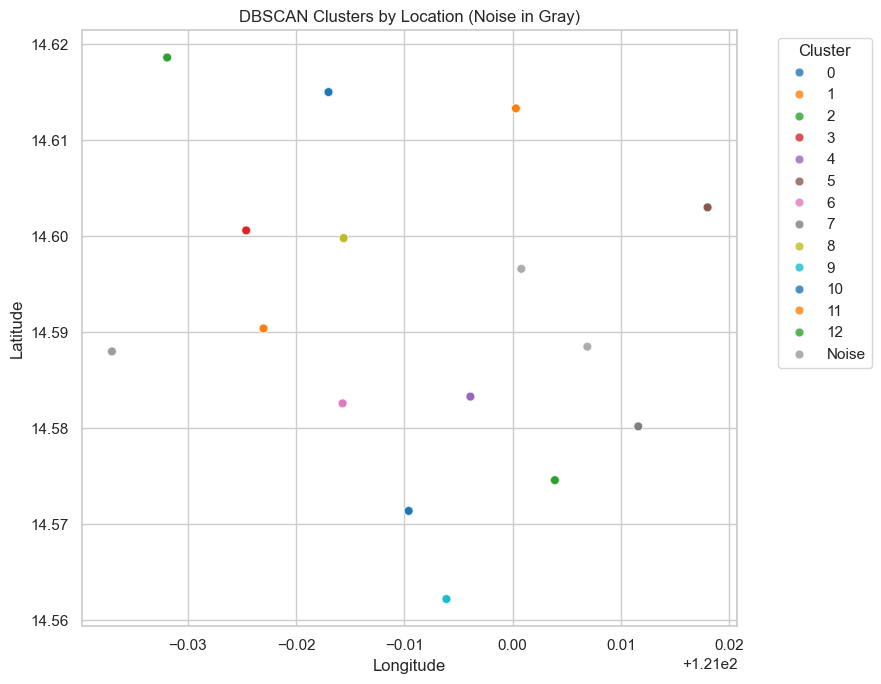

In [17]:
fig, ax = plt.subplots(figsize=(9, 7))
plot_df = geo_clustered.copy()
plot_df['Cluster_Label'] = plot_df['Cluster'].astype(str)
plot_df.loc[plot_df['Cluster'] == -1, 'Cluster_Label'] = 'Noise'

cluster_ids = sorted(c for c in plot_df['Cluster'].unique() if c != -1)
palette = sns.color_palette('tab10', n_colors=len(cluster_ids) or 1)
cluster_colors = {str(idx): color for idx, color in zip(cluster_ids, palette)}
cluster_colors['Noise'] = (0.6, 0.6, 0.6)

sns.scatterplot(
    data=plot_df,
    x='Longitude',
    y='Latitude',
    hue='Cluster_Label',
    palette=cluster_colors,
    s=40,
    alpha=0.8,
    ax=ax
 )
ax.set_title('DBSCAN Clusters by Location (Noise in Gray)')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
fig.savefig(OUTPUT_DIR / 'dbscan_clusters_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

In [18]:
geo_stats = geo_model.get_cluster_statistics(geo_clustered)
if not geo_stats.empty:
    geo_stats = geo_stats.rename(columns={'Top_Location': 'Top_District'})
    geo_stats = geo_stats.sort_values(by='Size', ascending=False).reset_index(drop=True)
display_columns = [col for col in geo_stats.columns if col not in {'Gender_Distribution', 'Age_Distribution'}]
geo_stats[display_columns]

,Cluster,Size,Percentage,Center_Lat,Center_Lon,Top_District,Top_Barangay
0,2,31,27.4%,14.618600,120.968100,Tondo,Unknown
1,1,13,11.5%,14.613300,121.000300,Sampaloc,Unknown
2,3,11,9.7%,14.600600,120.975400,Binondo,Unknown
3,0,10,8.8%,14.571400,120.990400,Malate,Unknown
4,10,10,8.8%,14.615000,120.983000,Santa Cruz,Unknown
5,7,6,5.3%,14.580200,121.011600,Santa Ana,Unknown
6,9,6,5.3%,14.562222,120.993889,Malate,Unknown
7,4,4,3.5%,14.583300,120.996100,Paco,Unknown
8,8,4,3.5%,14.599800,120.984400,Quiapo,Unknown
9,11,4,3.5%,14.590400,120.977000,Intramuros,Unknown


In [19]:
cluster_location_breakdown = (
    geo_clustered[geo_clustered['Cluster'] != -1]
    .groupby(['Cluster', 'Barangay District']).size().reset_index(name='Count')
)
cluster_location_breakdown.sort_values(['Cluster', 'Count'], ascending=[True, False]).head(25)

,Cluster,Barangay District,Count
0,0,Malate,10
1,1,Sampaloc,13
2,2,Tondo,31
4,3,Binondo,10
3,3,Barangay 287,1
5,4,Paco,4
6,5,Santa Mesa,3
7,6,Ermita,3
8,7,Santa Ana,6
9,8,Quiapo,4


In [20]:
manila_center = [plot_df['Latitude'].mean(), plot_df['Longitude'].mean()]
cluster_palette = sns.color_palette('tab10', len(cluster_ids) or 1).as_hex()
cluster_hex_map = {str(idx): color for idx, color in zip(cluster_ids, cluster_palette)}
cluster_hex_map['Noise'] = '#9e9e9e'

manila_map = folium.Map(location=manila_center, zoom_start=12, tiles='cartodbpositron')

for _, row in plot_df.iterrows():
    label = row['Cluster_Label']
    color = cluster_hex_map.get(label, '#3186cc')
    barangay_value = row.get('Barangay')
    district_value = row.get('District')
    barangay_label = barangay_value if barangay_value and barangay_value != 'Unknown' else 'District Fallback'
    district_label = district_value if district_value and district_value != 'Unknown' else 'Unknown'
    match_level = (row.get('Match_Level') or 'unknown').capitalize()
    match_score = row.get('Match_Score')
    score_text = f"{match_score:.2f}" if pd.notna(match_score) else 'N/A'
    popup_text = (
        f"ID: {row['Person_ID']}<br>"
        f"Barangay: {barangay_label}<br>"
        f"District: {district_label}<br>"
        f"Match Level: {match_level}<br>"
        f"Match Score: {score_text}<br>"
        f"Cluster: {label}"
    )
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=250)
    ).add_to(manila_map)

map_path = OUTPUT_DIR / 'dbscan_clusters_map.html'
manila_map.save(map_path)
map_html = manila_map._repr_html_()
display(HTML(map_html))
print(f"Map saved to {map_path.relative_to(Path.cwd())}")

ValueError: 'outputs/dbscan_clusters_map.html' is not in the subpath of '/Users/benny/missing-person-heatmap/notebook'

## Demographic Clustering (Age + Gender)
Next, we cluster by demographic features to identify groups with similar age/gender patterns. We encode gender into numeric form for clustering while keeping the original labels for interpretation.

In [ ]:
k_sweep_model = ClusteringModel()
k_results = k_sweep_model.find_optimal_k(
    demo_df,
    k_range=(2, 6),
    features=['Age', 'Gender_Code']
 )
k_metrics = (
    pd.DataFrame.from_dict(k_results, orient='index')
      .rename_axis('k')
      .reset_index()
)
k_metrics = k_metrics.sort_values(by='silhouette_score', ascending=False)
best_k = int(k_metrics.iloc[0]['k'])
display(k_metrics)
print(f"Selected K-means cluster count: k={best_k}")

✓ Evaluated K-means for k=2 to k=6


,k,inertia,silhouette_score,davies_bouldin_score
4,6,5.135147,0.641585,0.401381
3,5,7.374804,0.637739,0.429334
2,4,14.404219,0.635690,0.452734
1,3,25.966202,0.590565,0.566126
0,2,53.857922,0.557973,0.755489


Selected K-means cluster count: k=6


In [ ]:
demo_model = ClusteringModel()
demo_model.fit_kmeans(
    demo_df,
    n_clusters=best_k,
    features=['Age', 'Gender_Code']
 )
demo_clustered = demo_model.add_cluster_labels(demo_df)
demo_clustered.head()

✓ K-means clustering complete: 6 clusters identified


,Person_ID,Age,Gender,Age_Group,Gender_Code,Cluster
0,MP-0001,59.0,Male,Adult,1,1
1,MP-0002,41.0,Male,Adult,1,2
2,MP-0003,43.0,Male,Adult,1,2
3,MP-0004,14.0,Male,Young Teen,1,4
4,MP-0005,16.0,Male,Teen,1,4


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_df = demo_clustered.copy()
plot_df['Gender_Label'] = plot_df['Gender'].fillna('Unknown')
gender_order = plot_df['Gender_Label'].dropna().unique().tolist()
gender_order = [g for g in ['Female', 'Male', 'Unknown'] if g in gender_order] + [g for g in gender_order if g not in ['Female', 'Male', 'Unknown']]
gender_pos_map = {label: idx for idx, label in enumerate(gender_order)}
plot_df['Gender_Pos'] = plot_df['Gender_Label'].map(gender_pos_map)
unique_clusters = sorted(plot_df['Cluster'].unique())
cluster_palette = sns.color_palette('Set2', n_colors=len(unique_clusters))
palette_map = {cluster: color for cluster, color in zip(unique_clusters, cluster_palette)}
cluster_counts = plot_df['Cluster'].value_counts().sort_index()
sns.scatterplot(
    data=plot_df,
    x='Age',
    y='Gender_Pos',
    hue='Cluster',
    palette=palette_map,
    s=80,
    alpha=0.85,
    edgecolor='white',
    linewidth=0.6,
    ax=ax
 )
ax.grid(axis='x', linestyle='--', linewidth=0.6, alpha=0.6)
sns.despine(left=True, bottom=True)
ax.set_title('K-means Demographic Clusters (Age × Gender)', fontsize=16, pad=16)
ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Gender', fontsize=12)
ax.set_yticks(range(len(gender_order)))
ax.set_yticklabels(gender_order)
handles, labels = ax.get_legend_handles_labels()
legend_pairs = [(h, l) for h, l in zip(handles, labels) if l.isdigit()]
legend_handles = [h for h, _ in legend_pairs]
legend_labels = [f"Cluster {l} · n={cluster_counts[int(l)]}" for _, l in legend_pairs]
ax.legend(
    legend_handles,
    legend_labels,
    title='Cluster Summary',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    frameon=False
 )
ax.set_xlim(left=max(plot_df['Age'].min() - 2, 0))
ax.set_ylim(-0.5, len(gender_order) - 0.5)
for idx, label in enumerate(gender_order):
    ax.axhspan(idx - 0.4, idx + 0.4, color='lightgrey', alpha=0.08, zorder=0)
for cluster_id, color in palette_map.items():
    cluster_points = plot_df[plot_df['Cluster'] == cluster_id]
    if cluster_points.empty:
        continue
    mean_age = cluster_points['Age'].mean()
    mean_gender = cluster_points['Gender_Pos'].mean()
    age_std = cluster_points['Age'].std(ddof=0)
    width = float(np.nan_to_num(age_std, nan=0.0) * 3)
    if width == 0:
        width = 4
    height = 1.6 if cluster_points['Gender_Pos'].nunique() > 1 else 0.7
    ellipse = Ellipse(
        (mean_age, mean_gender),
        width=width,
        height=height,
        edgecolor=color,
        facecolor=color,
        alpha=0.14,
        linewidth=2,
        linestyle='--'
    )
    ax.add_patch(ellipse)
fig.tight_layout()
fig.savefig(OUTPUT_DIR / 'demographic_clusters_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

{'silhouette_score': 0.6415845353961503,
 'davies_bouldin_score': 0.4013805904973049,
 'inertia': 5.135146790583077,
 'n_clusters': 6,
 'n_samples': 54}

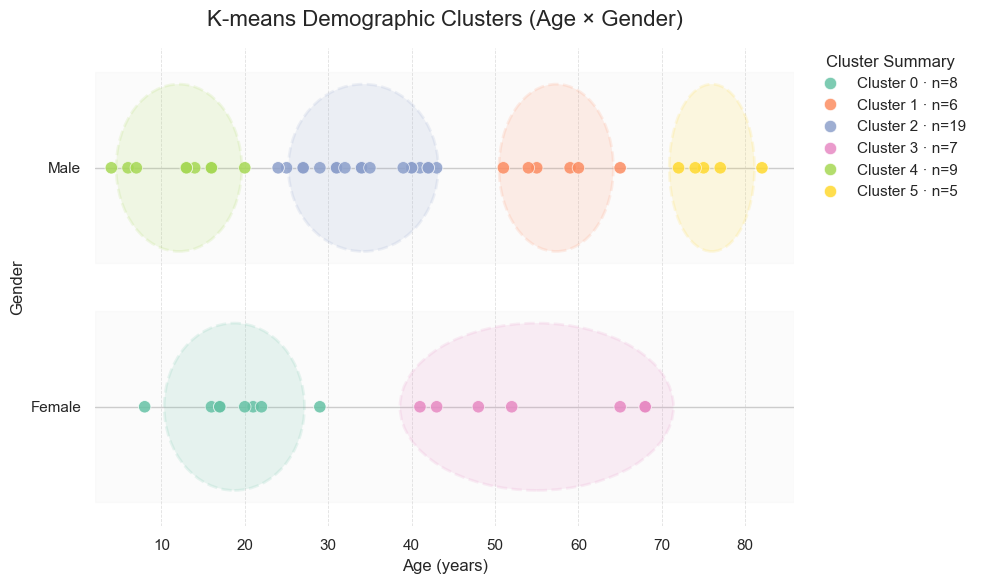

In [ ]:
plt.figure(figsize=(10, 6))
plot_df = demo_clustered.copy()
plot_df['Gender_Label'] = plot_df['Gender'].fillna('Unknown')
gender_order = plot_df['Gender_Label'].dropna().unique().tolist()
gender_order = [g for g in ['Female', 'Male', 'Unknown'] if g in gender_order] + [g for g in gender_order if g not in ['Female', 'Male', 'Unknown']]
gender_pos_map = {label: idx for idx, label in enumerate(gender_order)}
plot_df['Gender_Pos'] = plot_df['Gender_Label'].map(gender_pos_map)
unique_clusters = sorted(plot_df['Cluster'].unique())
cluster_palette = sns.color_palette('Set2', n_colors=len(unique_clusters))
palette_map = {cluster: color for cluster, color in zip(unique_clusters, cluster_palette)}
cluster_counts = plot_df['Cluster'].value_counts().sort_index()
ax = sns.scatterplot(
    data=plot_df,
    x='Age',
    y='Gender_Pos',
    hue='Cluster',
    palette=palette_map,
    s=80,
    alpha=0.85,
    edgecolor='white',
    linewidth=0.6
 )
ax.grid(axis='x', linestyle='--', linewidth=0.6, alpha=0.6)
sns.despine(left=True, bottom=True)
ax.set_title('K-means Demographic Clusters (Age × Gender)', fontsize=16, pad=16)
ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Gender', fontsize=12)
ax.set_yticks(range(len(gender_order)))
ax.set_yticklabels(gender_order)
handles, labels = ax.get_legend_handles_labels()
legend_pairs = [(h, l) for h, l in zip(handles, labels) if l.isdigit()]
legend_handles = [h for h, _ in legend_pairs]
legend_labels = [f"Cluster {l} · n={cluster_counts[int(l)]}" for _, l in legend_pairs]
ax.legend(
    legend_handles,
    legend_labels,
    title='Cluster Summary',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    frameon=False
 )
ax.set_xlim(left=max(plot_df['Age'].min() - 2, 0))
ax.set_ylim(-0.5, len(gender_order) - 0.5)
for idx, label in enumerate(gender_order):
    ax.axhspan(idx - 0.4, idx + 0.4, color='lightgrey', alpha=0.08, zorder=0)
for cluster_id, color in palette_map.items():
    cluster_points = plot_df[plot_df['Cluster'] == cluster_id]
    if cluster_points.empty:
        continue
    mean_age = cluster_points['Age'].mean()
    mean_gender = cluster_points['Gender_Pos'].mean()
    age_std = cluster_points['Age'].std(ddof=0)
    width = float(np.nan_to_num(age_std, nan=0.0) * 3)
    if width == 0:
        width = 4
    height = 1.6 if cluster_points['Gender_Pos'].nunique() > 1 else 0.7
    ellipse = Ellipse(
        (mean_age, mean_gender),
        width=width,
        height=height,
        edgecolor=color,
        facecolor=color,
        alpha=0.14,
        linewidth=2,
        linestyle='--'
    )
    ax.add_patch(ellipse)
plt.tight_layout()

In [ ]:
demo_stats = demo_model.get_cluster_statistics(demo_clustered)
demo_stats

,Cluster,Size,Percentage,Center_Lat,Center_Lon,Gender_Distribution,Age_Distribution
0,0,8,14.8%,None,None,{'Female': 8},"{'Teen': 3, 'Young Adult': 3, 'Adult': 1, 'Chi..."
1,1,6,11.1%,None,None,{'Male': 6},"{'Adult': 4, 'Old': 2}"
2,2,19,35.2%,None,None,{'Male': 19},"{'Adult': 18, 'Young Adult': 1}"
3,3,7,13.0%,None,None,{'Female': 7},"{'Adult': 4, 'Old': 3}"
4,4,9,16.7%,None,None,{'Male': 9},"{'Young Teen': 3, 'Child': 3, 'Teen': 2, 'Youn..."
5,5,5,9.3%,None,None,{'Male': 5},{'Old': 5}
